### Please note that these two pip install commands for FBProphet and supporting package are just to show I know how to insall them manually and via Requirements.txt

### Unfortunately after many hours of troubleshooting, I was unable to resolve issues to get the packages working in docker.

### I did not pin any of the packages added to requirements due to the nature of this assignment but would depending on a projects requirements.

In [1]:
# pip install pystan

In [2]:
# pip install fbprophet

In [11]:
#Import required packages

#Reducing warning outputs for depreciated packages to make export of html smaller
import warnings; warnings.simplefilter('ignore'); warnings.filterwarnings('ignore');


import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error

In [12]:
# Read in data and verify its shape
# Verify date is in ascending order as it is a timeseries
orig_data = pd.read_excel("./forecasting_take_home_data.xlsx", skiprows=11, names=["date", "gas_price"])
display(orig_data)
orig_data = orig_data.sort_values('date', ascending=True)

,date,gas_price
0,1992-01-01,1.022
1,1992-02-01,1.006
2,1992-03-01,1.013
3,1992-04-01,1.052
4,1992-05-01,1.107
...,...,...
308,2017-09-01,2.570
309,2017-10-01,2.430
310,2017-11-01,2.474
311,2017-12-01,2.388


## Product Summary Statistics and Basic Plots To Analyze The Data

In [13]:
orig_data['gas_price'].describe()

# Based on these summary statistics I would suspect taht the data will be slightly left skewed as the median is slightly lower than the mean

count    313.000000
mean       2.026236
std        0.893544
min        0.900000
25%        1.188000
50%        1.863000
75%        2.700000
max        4.002000
Name: gas_price, dtype: float64

Text(0.5, 1.0, 'Exploration Of US Gasoline Prices')

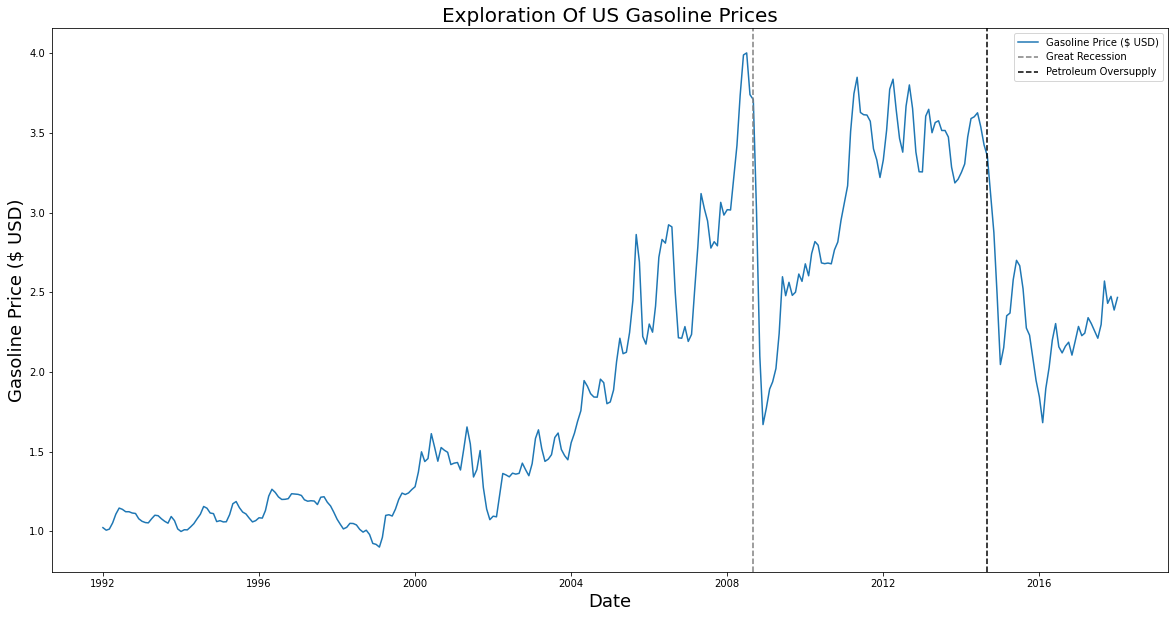

In [14]:
plt.figure(figsize=[20,10])
plt.plot(orig_data['date'],orig_data['gas_price'])
plt.axvline(x="2008-09-01",color="gray", linestyle='--')
# We see that there was a plummit in gasoline prices during the Great Recession
# Upon further reserach we find that the 2014 drop in prices were not due to recession related factors but instead due to a oversupply of petroleum on the world market per: https://www.bls.gov/opub/btn/volume-4/pdf/the-2014-plunge-in-import-petroleum-prices-what-happened.pdf


plt.axvline(x="2014-09-01",color="black", linestyle='--')
plt.legend(["Gasoline Price ($ USD)","Great Recession", "Petroleum Oversupply"],loc="upper right")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Gasoline Price ($ USD)", fontsize=18)
plt.title("Exploration Of US Gasoline Prices", fontsize=20)


Text(0, 0.5, 'Count Of Price Occurance')

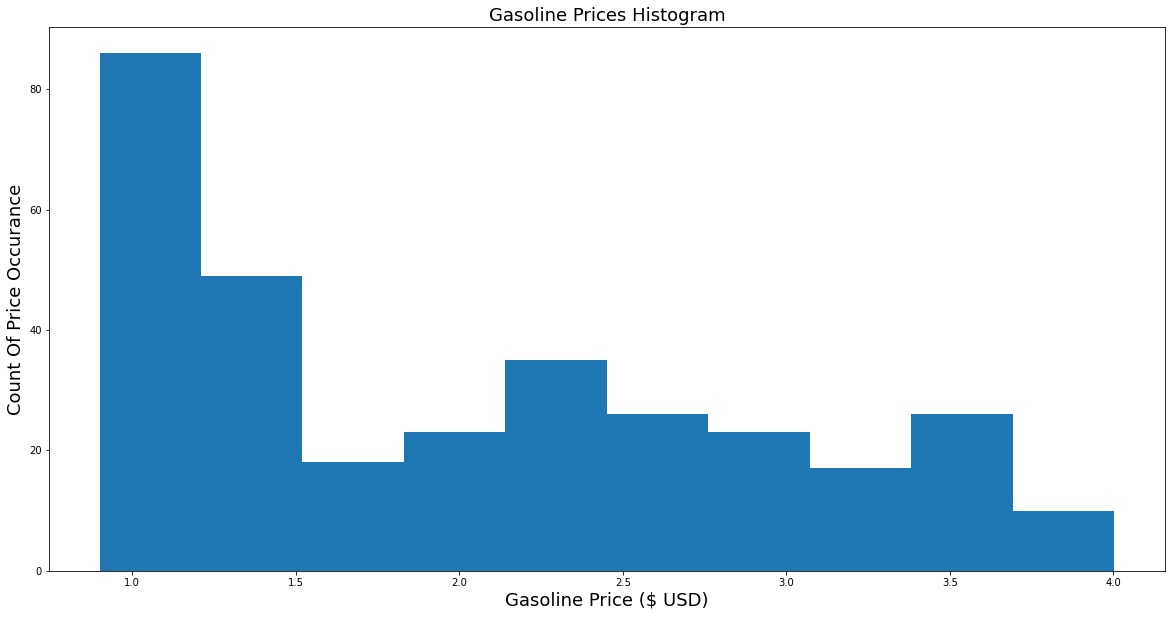

In [15]:
plt.figure(figsize=(20,10))
plt.hist(orig_data['gas_price'])
plt.title("Gasoline Prices Histogram", fontsize=18)
plt.xlabel("Gasoline Price ($ USD)", fontsize=18)
plt.ylabel("Count Of Price Occurance", fontsize=18)

## Begin FBProphet Package Modelling

In [16]:
data = orig_data.rename(columns={"date":"ds", "gas_price": "y"})

In [17]:
train_split_point = int(data.shape[0]*.7)

In [18]:
train = data[0:train_split_point]
test = data[train_split_point:len(data)]

In [19]:
future_df = pd.DataFrame(test["ds"])

In [20]:
mod = Prophet(seasonality_mode='multiplicative').fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# Source: https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
df_cv = cross_validation(mod, horizon="730 days")

INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00


In [22]:
df_p = performance_metrics(df_cv)

In [23]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,90 days,0.051963,0.227954,0.191622,0.105828,0.098348,0.346154
1,91 days,0.057909,0.240644,0.210800,0.109071,0.103023,0.269231
2,92 days,0.074249,0.272486,0.229525,0.112168,0.103023,0.259615
3,119 days,0.072052,0.268425,0.225992,0.116292,0.103023,0.240385
4,120 days,0.075675,0.275091,0.229108,0.121537,0.106272,0.307692
...,...,...,...,...,...,...,...
81,701 days,0.311534,0.558152,0.456671,0.247333,0.209506,0.115385
82,702 days,0.374843,0.612244,0.502569,0.269207,0.252376,0.115385
83,728 days,0.310617,0.557330,0.455441,0.257738,0.222833,0.153846
84,729 days,0.321935,0.567393,0.474549,0.252366,0.209506,0.096154


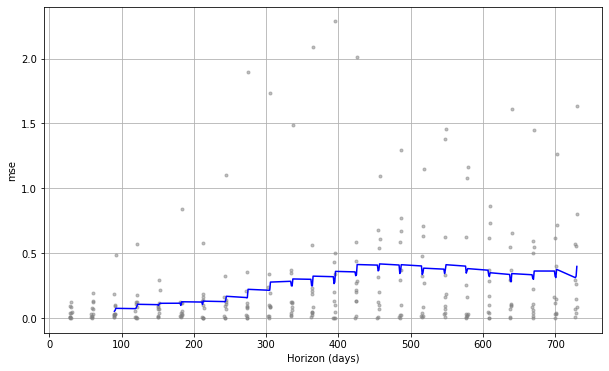

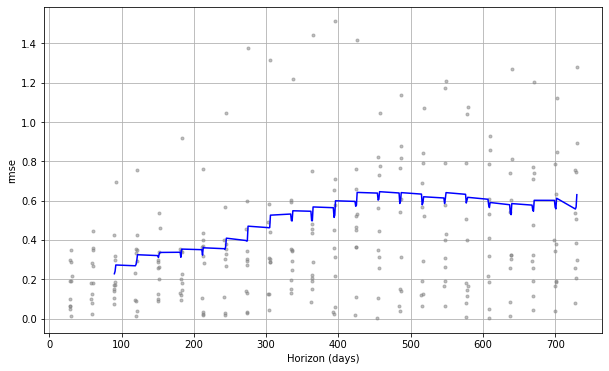

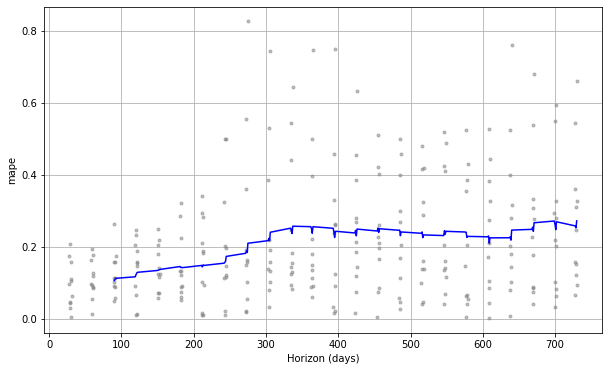

In [24]:
metrics = ["mse", "rmse", "mape"]

for ea in metrics:
    plot_cross_validation_metric(df_cv, metric=ea)

## After viewing a default fitting of prophet, we will try to hyperparameter turn the model. Code/Information source: https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

In [25]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, .05, 0.1, .25, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mse = []
rmse = []
mape = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, seasonality_mode='multiplicative').fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='730 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mse.append(df_p['mse'].values[0])
    rmse.append(df_p['rmse'].values[0])
    mape.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mse
tuning_results['rmse'] = rmse
tuning_results['mape'] = mape

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 2008-03-01 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 1998-03-04 00:00:00 and 20

In [26]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,mse,rmse,mape
0,0.001,0.01,0.350309,0.591869,0.591869
1,0.001,0.10,0.338540,0.581842,0.581842
2,0.001,0.50,0.340068,0.583153,0.583153
3,0.001,1.00,0.340258,0.583316,0.583316
4,0.001,5.00,0.340316,0.583366,0.583366
5,0.001,10.00,0.341975,0.584786,0.584786
6,0.010,0.01,0.332510,0.576637,0.576637
7,0.010,0.10,0.326377,0.571294,0.571294
8,0.010,0.50,0.321442,0.566958,0.566958
9,0.010,1.00,0.317628,0.563585,0.563585


In [27]:
minimums = tuning_results.iloc[:,2:].min()

In [28]:
print(tuning_results.loc[tuning_results["mse"]==minimums[0]])
print(tuning_results.loc[tuning_results["rmse"]==minimums[1]])
print(tuning_results.loc[tuning_results["mape"]==minimums[2]])

    changepoint_prior_scale  seasonality_prior_scale       mse      rmse  \
15                     0.05                      1.0  0.254805  0.504782   

        mape  
15  0.504782  
    changepoint_prior_scale  seasonality_prior_scale       mse      rmse  \
15                     0.05                      1.0  0.254805  0.504782   

        mape  
15  0.504782  
    changepoint_prior_scale  seasonality_prior_scale       mse      rmse  \
15                     0.05                      1.0  0.254805  0.504782   

        mape  
15  0.504782  


In [29]:
final_mod = Prophet(changepoint_prior_scale=.05, seasonality_prior_scale=1.0, seasonality_mode='multiplicative').fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
final_predicted = final_mod.predict(test)

In [31]:
comparison_df = pd.merge(test, final_predicted ,how="inner", on="ds")

Text(0.5, 1.0, 'Actual vs. Predicted')

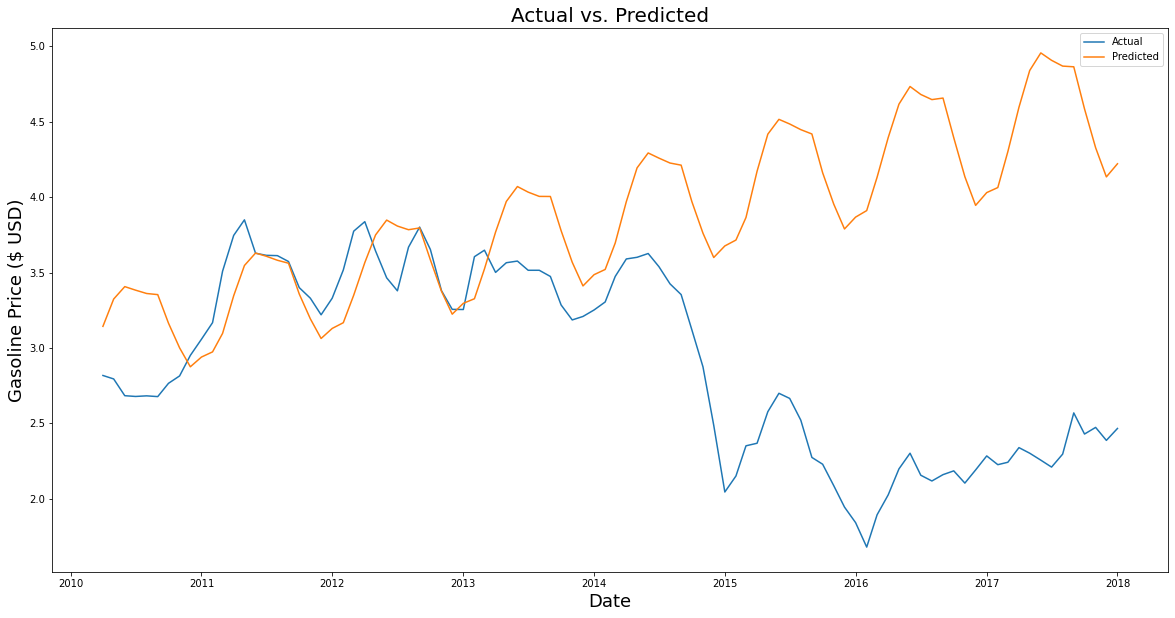

In [32]:
plt.figure(figsize=[20,10])
plt.plot(comparison_df["ds"],comparison_df["y"])
plt.plot(comparison_df["ds"],comparison_df["yhat"])
plt.legend(["Actual","Predicted"],loc="upper right")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Gasoline Price ($ USD)", fontsize=18)
plt.title("Actual vs. Predicted", fontsize=20)

In [33]:
print("Mean Squared Error: {0}".format(mean_squared_error(comparison_df["y"],comparison_df["yhat"])))
print("Root Mean Squared Error: {0}".format(mean_squared_error(comparison_df["y"],comparison_df["yhat"], squared=False)))

print("Mean Absolute Percentage Error: {0}".format(np.mean(np.abs((comparison_df["y"]-comparison_df["yhat"])/comparison_df["y"]))))

## I would suspect that the very large prediction errors are causing the RMSE and MSE to go over 1. These are not very good predictions.

Mean Squared Error: 1.8731274303456362
Root Mean Squared Error: 1.3686224571976144
Mean Absolute Percentage Error: 0.4368298265246836
